# OVERVIEW

1. Announcements
2. Recap
3. Bias-variance tradeoff
4. List comprehension
5. One hot encoding
6. Ridge regression
7. Feature importances


#What’s our goal for this guided project?
* Improve our NYC rent model. 
#What are the core learning objectives that will allow us to meet that goal?
* Do one-hot encoding of categorical features.
* Use scikit-learn to fit a Ridge Regression model.

#What’s my plan for today’s project?
1. Perform EDA on our NYC rent data set
2. One hot encode categorical features
3. Build a ridge regression model
#What else?
* Review module project


In [ ]:
# Model Building
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For running this notebook either locally or in colab
import sys

In [ ]:
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

     |████████████████████████████████| 80 kB 3.4 MB/s 


In [ ]:
# For encoding categorical data
from category_encoders import OneHotEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# NYC Rent

**GOAL:** Improve our model for predicting NYC rent prices.

**Objectives**

- Do one-hot encoding of categorical features
- Do univariate feature selection
- Use scikit-learn to fit Ridge Regression models

# I. Wrangle Data

Create **wrangle function** for **reproducibility**.

In [ ]:
def wrangle(filepath):
  df = pd.read_csv(filepath, parse_dates=['created'],index_col='created')
  
  # Remove outlier observations
  df = df[(df['price'] >= np.percentile(df['price'], 0.05)) & 
          (df['price'] <= np.percentile(df['price'], 99.5)) & 
          (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
          (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
          (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
          (df['longitude'] <= np.percentile(df['longitude'], 99.95))]


  #Remove high cardinal features
  # threshold = 10
  # cols_to_remove = []
  # for cols in df.select_dtypes('object').columns:
  #   if df[cols].nunique() > threshold:
  #     cols_to_remove.append(cols)

  # list comprehension - this condenses everything listed above
  cols_to_remove = [cols for cols in df.select_dtypes('object').columns if df[cols].nunique() > (.75*len('created'))]
  df.drop(columns=cols_to_remove,inplace=True)

  return df

df = wrangle(DATA_PATH+'apartments/renthop-nyc.csv')

# II. Split Data

Split **target vector** from **feature matrix**.

In [ ]:
target = 'price'

y = df[target]
X = df.drop(columns=target)

Split data into **training** and **test** sets.

(Use data from April & May 2016 to train. Use data from June 2016 to test.)

In [ ]:
# Create a cutoffdate for your mask
cutoff = '2016-6-01'
# Create a mask using the cutoff date
mask = X.index < cutoff
# Split the training data based on the cutoff date
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

# III. Establish Baseline

**Note:** This is a **regression** problem because we're predictiong the continuous value `'price'`.

In [ ]:
y_pred = [y_train.mean()] * len(y_train)
print('Mean price by the baseline prediction:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train,y_pred))
print('Baseline RMSE:', mean_squared_error(y_train,y_pred,squared = False))

Mean price by the baseline prediction: 3565.095561112848
Baseline MAE: 1203.9726810650523
Baseline RMSE: 1764.9257869773612


# IV. Build Models

**Question:** How can we represent *categorical* features numerically so that we can use them to train our model?

In [ ]:
# Step 1: import OHE (already done as part of the header)

# Step 2: instantiate your transformer
ohe = OneHotEncoder(use_cat_names=True)

# Step 3: Transform your data using the fit command
ohe_fit = ohe.fit(X_train)
XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**Model 1:** Regular ol' linear regression

In [ ]:
model_lr = LinearRegression()
model_lr.fit(XT_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Model 2:** Ridge regression (regularization)

In [ ]:
model_rr = Ridge()
model_rr.fit(XT_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

# V. Check Metrics

In [ ]:
print('Training MAE for LR:', mean_absolute_error(y_train,model_lr.predict(XT_train)))
print('Training MAE for LR:', mean_absolute_error(y_test,model_lr.predict(XT_test)))

Training MAE for LR: 672.5004620674722
Training MAE for LR: 676.2468313173481


In [ ]:
print('Training MAE for RR:', mean_absolute_error(y_train,model_rr.predict(XT_train)))
print('Training MAE for RR:', mean_absolute_error(y_test,model_rr.predict(XT_test)))

Training MAE for RR: 672.0351683623206
Training MAE for RR: 675.6640925954118


# Communicate results

In [ ]:
coef_lr = model_lr.coef_
features = ohe.get_feature_names()
feature_importance = pd.Series(coef_lr,index=features).sort_values()

In [ ]:
feature_importance

longitude               -12915.376941
interest_level_high       -303.748986
high_speed_internet       -293.488210
roof_deck                 -163.032592
common_outdoor_space      -152.284943
hardwood_floors           -140.466538
new_construction          -132.712891
laundry_in_building       -105.638776
no_fee                    -102.749016
interest_level_medium     -101.162520
pre-war                    -90.163071
outdoor_space              -79.714220
balcony                    -44.895842
garden_patio               -42.511372
cats_allowed               -33.146061
swimming_pool               55.900715
dishwasher                  57.699454
dogs_allowed                74.669721
fitness_center             117.910595
exclusive                  135.386653
loft                       136.971673
elevator                   147.633881
wheelchair_access          174.125800
terrace                    179.789849
dining_room                257.826357
interest_level_low         404.911506
doorman     

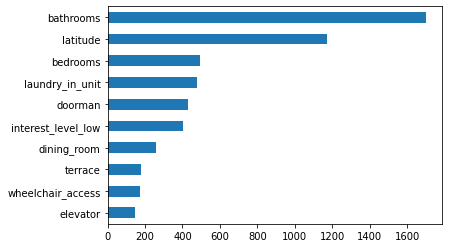

In [ ]:
feature_importance.tail(10).plot(kind='barh')
plt.show();

In [ ]:
coef_rr = model_rr.coef_
features = ohe.get_feature_names()
feature_importance = pd.Series(coef_rr,index=features).sort_values()

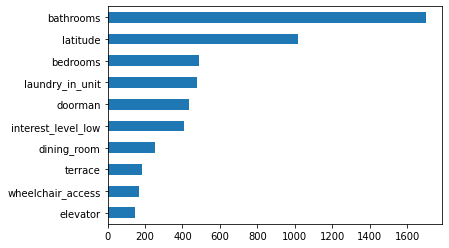

In [ ]:
feature_importance.tail(10).plot(kind='barh')
plt.show();

In [ ]:
feature_importance

longitude               -12341.324027
interest_level_high       -305.912742
high_speed_internet       -292.268007
roof_deck                 -162.527000
common_outdoor_space      -147.996239
hardwood_floors           -139.026401
new_construction          -132.610812
laundry_in_building       -104.371877
no_fee                    -103.079348
interest_level_medium     -100.826758
pre-war                    -89.424380
outdoor_space              -80.434796
balcony                    -45.689928
garden_patio               -42.728390
cats_allowed               -35.257192
swimming_pool               55.645884
dishwasher                  60.163409
dogs_allowed                78.026612
fitness_center             120.623259
exclusive                  132.059866
loft                       140.603283
elevator                   148.009338
wheelchair_access          170.377839
terrace                    181.605171
dining_room                254.577898
interest_level_low         406.739500
doorman     